In [6]:
import pandas as pd

# 📌 CSV 파일 경로 설정
file_paths = {
    "ERTH": "ERTH.csv",
    "GSPC": "GSPC.csv",
    "SUSA": "SUSA.csv",
    "TAN": "TAN.csv",
    "VDE": "VDE.csv"
}

# 📌 데이터 로드 및 정리
dataframes = {}
for etf, path in file_paths.items():
    df = pd.read_csv(path, index_col=0, parse_dates=True, skiprows=[0, 1])  # 첫 두 행 제거
    df.columns = ["Close", "High", "Low", "Open", "Volume"]  # 컬럼명 재설정
    df = df[["Close"]]  # 종가만 선택
    df.rename(columns={'Close': etf}, inplace=True)  # 컬럼명을 ETF 이름으로 변경
    dataframes[etf] = df

# ✅ 데이터 샘플 확인
dataframes["ERTH"].head()


,ERTH
Date,
2016-01-04,23.391020
2016-01-05,23.358635
2016-01-06,22.897135
2016-01-07,22.208920
2016-01-08,22.038898


In [7]:
# 📌 모든 데이터 합치기
merged_data = pd.concat(dataframes.values(), axis=1, join="inner")

# ✅ 병합된 데이터 확인
merged_data.head()


,ERTH,GSPC,SUSA,TAN,VDE
Date,,,,,
2016-01-04,23.391020,2012.660034,35.959999,28.320396,60.456028
2016-01-05,23.358635,2016.709961,36.122528,27.887814,60.674248
2016-01-06,22.897135,1990.260010,35.542736,27.344782,58.317413
2016-01-07,22.208920,1943.089966,34.897064,24.841322,56.862553
2016-01-08,22.038898,1922.030029,34.435875,25.126644,56.142406


In [8]:
# 📌 일반수익률 계산
simple_returns = merged_data.pct_change().dropna()

# ✅ 데이터 확인
print("\n📌 일반수익률 샘플:")
simple_returns.head()



📌 일반수익률 샘플:


,ERTH,GSPC,SUSA,TAN,VDE
Date,,,,,
2016-01-05,-0.001385,0.002012,0.004520,-0.015275,0.003610
2016-01-06,-0.019757,-0.013115,-0.016051,-0.019472,-0.038844
2016-01-07,-0.030057,-0.023700,-0.018166,-0.091552,-0.024947
2016-01-08,-0.007656,-0.010838,-0.013216,0.011486,-0.012665
2016-01-11,-0.013960,0.000853,-0.001913,-0.035897,-0.022674


In [9]:
import statsmodels.api as sm

# 📌 추정 윈도우 설정
estimation_start = "2016-01-06"
estimation_end = "2016-12-30"

# 📌 벤치마크(S&P500) 수익률
market_returns = simple_returns["GSPC"]

# 📌 ETF별 α(알파), β(베타) 추정
alpha_beta = {}

for etf in simple_returns.columns:
    if etf == "GSPC":
        continue  # 벤치마크 제외

    etf_returns = simple_returns[etf]

    # 📌 추정 기간의 데이터 선택
    estimation_index = (market_returns.index >= estimation_start) & (market_returns.index <= estimation_end)
    X = market_returns.loc[estimation_index]
    Y = etf_returns.loc[estimation_index]

    # 📌 OLS 회귀 분석
    X = sm.add_constant(X)  # 상수항 추가 (α 추정)
    model = sm.OLS(Y, X).fit()

    # 결과 저장
    alpha, beta = model.params
    alpha_beta[etf] = {"alpha": alpha, "beta": beta}

# ✅ α, β 값 확인
print("\n📌 ETF별 α(알파), β(베타) 값:")
for etf, params in alpha_beta.items():
    print(f"{etf}: α = {params['alpha']:.6f}, β = {params['beta']:.6f}")



📌 ETF별 α(알파), β(베타) 값:
ERTH: α = 0.000098, β = 1.137832
SUSA: α = 0.000109, β = 0.970845
TAN: α = -0.002699, β = 1.458828
VDE: α = 0.000511, β = 1.401326


In [12]:
event_dates = ['2017-01-25', # 트럼프 행정부가 EPA(환경보호청) 직원들에게 언론 보도, 블로그 업데이트, 소셜 미디어 게시를 금지
               '2017-02-14', # 트럼프가 오바마 행정부 시절의 화석연료 산업 관련 금융 규제를 폐지하는 법안에 서명
               '2017-02-28', # 트럼프가 오바마 행정부의 'Clean Water Rule'을 폐지하는 행정명령에 서명
               '2017-03-28', # 트럼프가 오바마 행정부의 기후 정책들을 무효화하는 행정명령에 서명
               '2017-04-28', # 트럼프가 해상 석유 및 가스 시추를 확대하는 행정명령에 서명
               '2017-06-01', # 트럼프가 파리기후협정 탈퇴를 공식 발표
               '2017-10-13', # 트럼프가 캐슬린 하트넷-화이트(기후변화에 대해 회의적인 입장을 가진 인물)를 백악관 환경품질위원회 의장으로 지명
               '2018-06-19', # 트럼프 대통령은 '미국의 경제, 안보, 환경 이익을 증진하기 위한 해양 정책'에 관한 행정명령 13840에 서명
               '2018-08-21', # 트럼프 행정부의 환경보호청(EPA)이 오바마 행정부의 'Clean Power Plan'을 폐기하고 이를 대체하는 'Affordable Clean Energy Rule' 제안서를 발표
               '2019-04-12', # 트럼프가 주주들의 기후변화 관련 요구를 제한하는 행정명령에 서명
               '2019-06-20', # 트럼프 행정부의 환경보호청(EPA)이 오바마 행정부의 주요 기후변화 정책인 'Clean Power Plan'을 폐지하고 이를 대체하는 'Affordable Clean Energy' 규칙을 최종 확정
               '2019-11-04', # 트럼프가 유엔에 파리기후협정 탈퇴 의사를 공식 통보
               '2020-06-05', # 트럼프 대통령은 대서양 유일의 해양 국립기념물인 Northeast Canyons and Seamounts Marine National Monument의 보호 조치를 철회하는 선언에 서명
               '2020-11-01'] # 트럼프 대통령은 수압파쇄법(석유와 천연가스를 추출하는 특수한 시추 기술) 보호를 위한 행정명령에 서명

In [19]:
# 📌 비정상 수익률(AR) 저장용 딕셔너리 초기화
abnormal_returns = {}

for date in simple_returns.index:
    abnormal_returns[date] = {}

    for etf in simple_returns.columns:
        if etf == "GSPC":
            continue  # 벤치마크 제외

        # 기대수익률 계산
        alpha = alpha_beta[etf]["alpha"]
        beta = alpha_beta[etf]["beta"]
        expected_return = alpha + beta * simple_returns.loc[date, "GSPC"]

        # 비정상 수익률 (AR) 계산
        abnormal_return = simple_returns.loc[date, etf] - expected_return
        abnormal_returns[date][etf] = abnormal_return

# ✅ AR 샘플 확인
print("\n📌 일부 날짜의 비정상 수익률(AR) 샘플:")
for date, etf_data in list(abnormal_returns.items())[:5]:  # 처음 5개 날짜만 출력
    print(f"📌 날짜 {date}:")
    for etf, ar in etf_data.items():
        print(f"  - {etf}: {ar:.6f}")



📌 일부 날짜의 비정상 수익률(AR) 샘플:
📌 날짜 2016-01-05 00:00:00:
  - ERTH: -0.003772
  - SUSA: 0.002458
  - TAN: -0.015511
  - VDE: 0.000278
📌 날짜 2016-01-06 00:00:00:
  - ERTH: -0.004932
  - SUSA: -0.003426
  - TAN: 0.002360
  - VDE: -0.020976
📌 날짜 2016-01-07 00:00:00:
  - ERTH: -0.003187
  - SUSA: 0.004735
  - TAN: -0.054278
  - VDE: 0.007753
📌 날짜 2016-01-08 00:00:00:
  - ERTH: 0.004579
  - SUSA: -0.002802
  - TAN: 0.029996
  - VDE: 0.002012
📌 날짜 2016-01-11 00:00:00:
  - ERTH: -0.015029
  - SUSA: -0.002850
  - TAN: -0.034444
  - VDE: -0.024381


In [29]:
# 📌 이벤트 전후 5일 동안의 날짜별 CAR 계산
event_window = 5  # 이벤트 전후 5일
event_car = {}

for event in event_dates:
    event_day = pd.to_datetime(event)

    # 이벤트일이 거래일이 아닐 경우, 가장 가까운 이전 거래일 찾기
    if event_day not in simple_returns.index:
        event_day = simple_returns.index[simple_returns.index.searchsorted(event_day, side='left') - 1]

    # 이벤트 전후 5일 범위 설정
    idx = simple_returns.index.get_loc(event_day)  # 이벤트일의 위치 찾기
    start_idx = max(0, idx - event_window)  # 이벤트 전 5일
    end_idx = min(len(simple_returns.index) - 1, idx + event_window)  # 이벤트 후 5일

    start_date = simple_returns.index[start_idx]
    end_date = simple_returns.index[end_idx]

    event_car[event] = {}

    for etf in simple_returns.columns:
        if etf == "GSPC":
            continue  # 벤치마크 제외

        # 날짜별 CAR 계산 (이벤트 전후 5일 동안 누적)
        cumulative_sum = 0
        daily_car = {}  # 날짜별 CAR 저장

        for d in simple_returns.index[start_idx:end_idx+1]:
            if d in abnormal_returns:
                cumulative_sum += abnormal_returns[d][etf]  # AR 누적
            daily_car[d] = cumulative_sum  # 해당 날짜까지의 누적 CAR 저장

        # 날짜별 CAR 리스트 저장
        event_car[event][etf] = daily_car if daily_car else None  # 데이터 없으면 None

# ✅ 이벤트별 날짜별 CAR 샘플 확인
print("\n📌 이벤트별 날짜별 CAR 샘플:")
for event, etf_data in list(event_car.items())[:2]:  # 처음 2개 이벤트만 출력
    print(f"📌 이벤트 {event}:")
    for etf, car_dict in etf_data.items():
        print(f"  - {etf}:")
        for date, car in list(car_dict.items()):  # 이벤트 전후 5일 모두 출력
            print(f"    {date}: {car:.6f}")



📌 이벤트별 날짜별 CAR 샘플:
📌 이벤트 2017-01-25:
  - ERTH:
    2017-01-18 00:00:00: -0.007173
    2017-01-19 00:00:00: -0.006760
    2017-01-20 00:00:00: -0.006477
    2017-01-23 00:00:00: -0.001418
    2017-01-24 00:00:00: 0.002671
    2017-01-25 00:00:00: 0.004076
    2017-01-26 00:00:00: -0.001324
    2017-01-27 00:00:00: 0.003094
    2017-01-30 00:00:00: -0.002768
    2017-01-31 00:00:00: 0.004083
    2017-02-01 00:00:00: 0.005712
  - SUSA:
    2017-01-18 00:00:00: -0.000318
    2017-01-19 00:00:00: -0.002174
    2017-01-20 00:00:00: -0.003073
    2017-01-23 00:00:00: 0.001902
    2017-01-24 00:00:00: 0.003139
    2017-01-25 00:00:00: 0.002898
    2017-01-26 00:00:00: -0.001248
    2017-01-27 00:00:00: -0.002637
    2017-01-30 00:00:00: -0.003502
    2017-01-31 00:00:00: -0.002104
    2017-02-01 00:00:00: -0.001861
  - TAN:
    2017-01-18 00:00:00: -0.003807
    2017-01-19 00:00:00: -0.000919
    2017-01-20 00:00:00: -0.000297
    2017-01-23 00:00:00: 0.001804
    2017-01-24 00:00:00: -0.0101

### 이벤트 전후 5일씩

C:\Users\chica\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chica\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


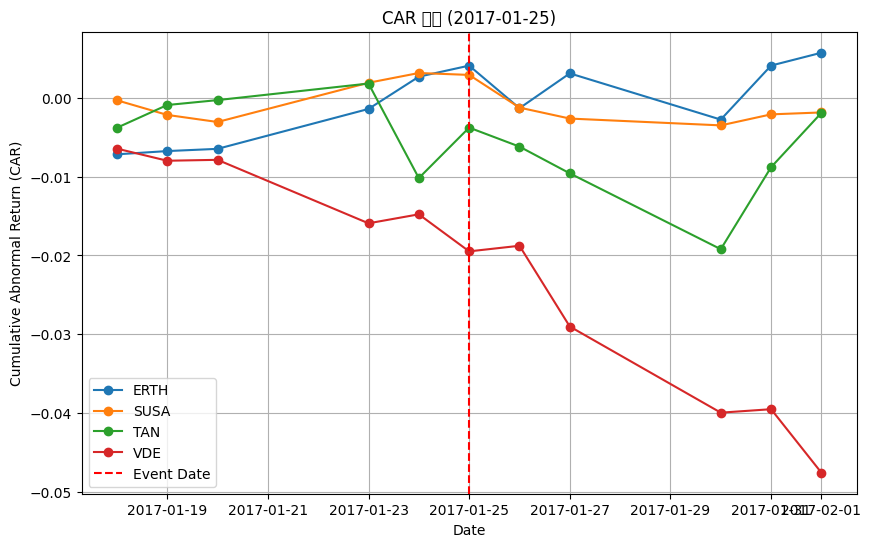

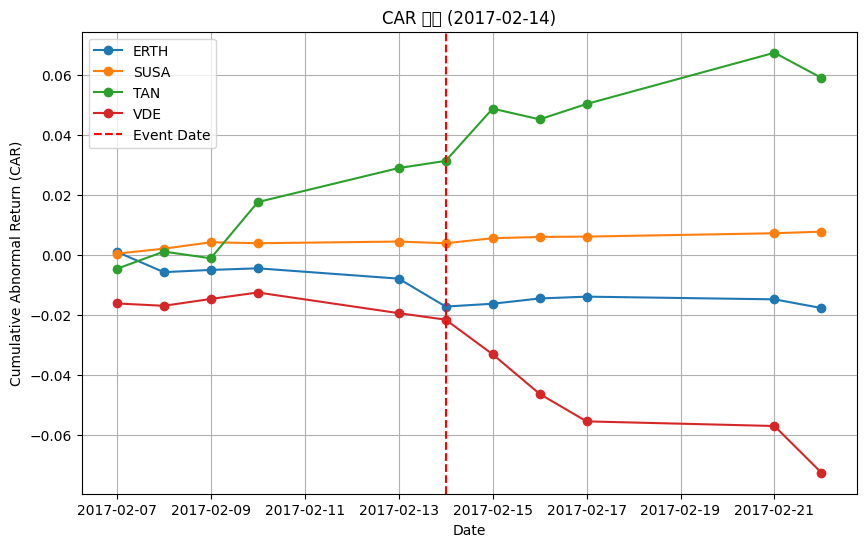

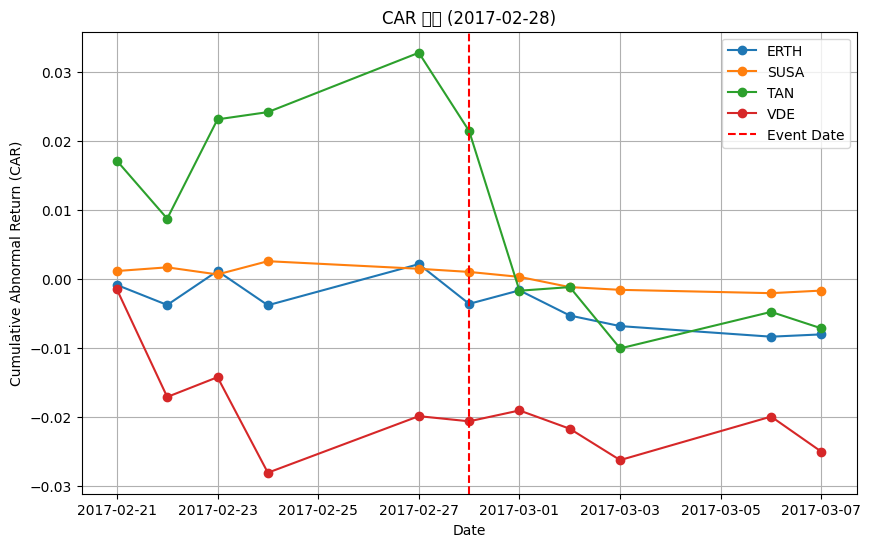

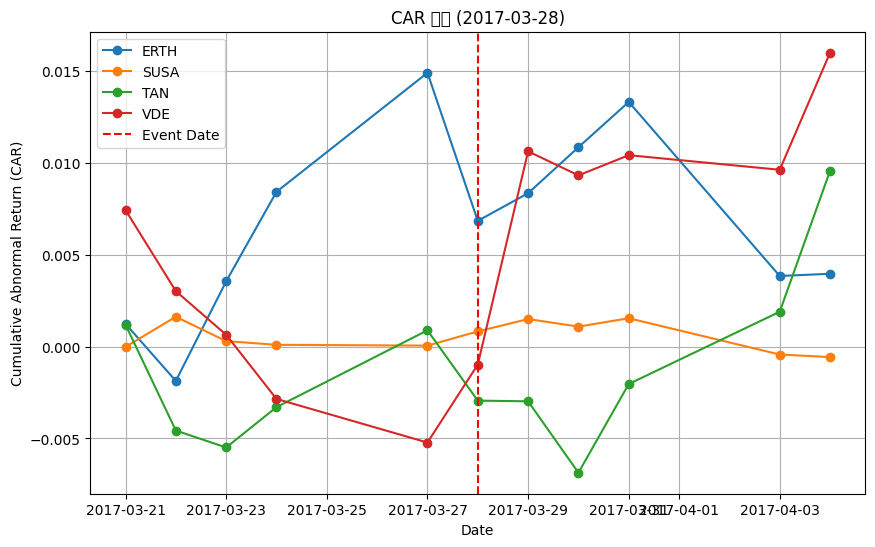

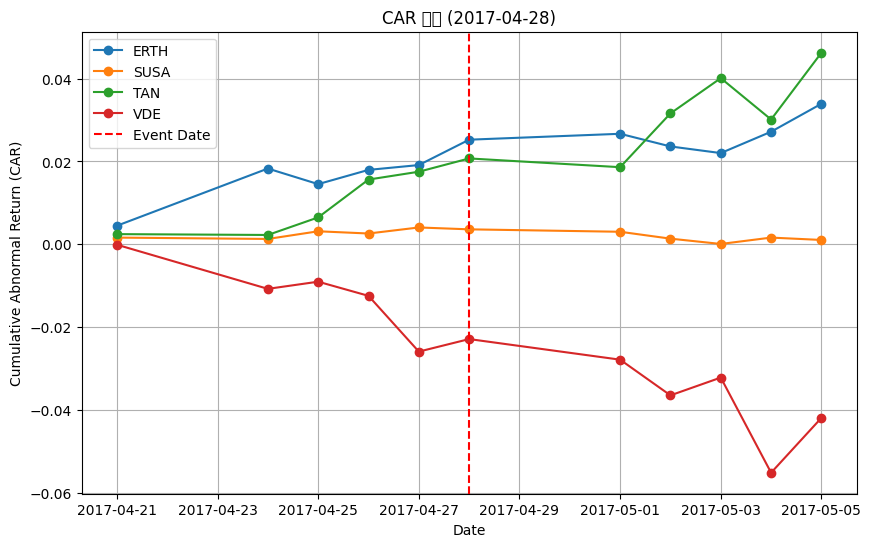

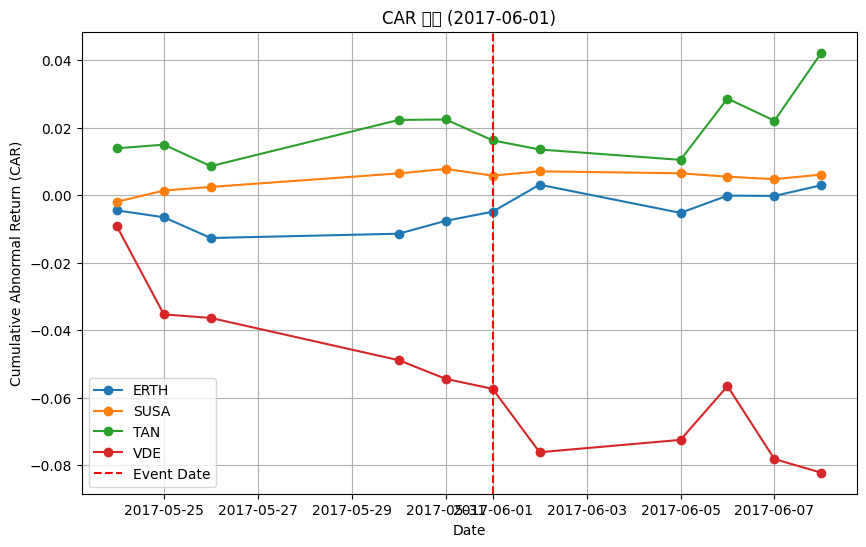

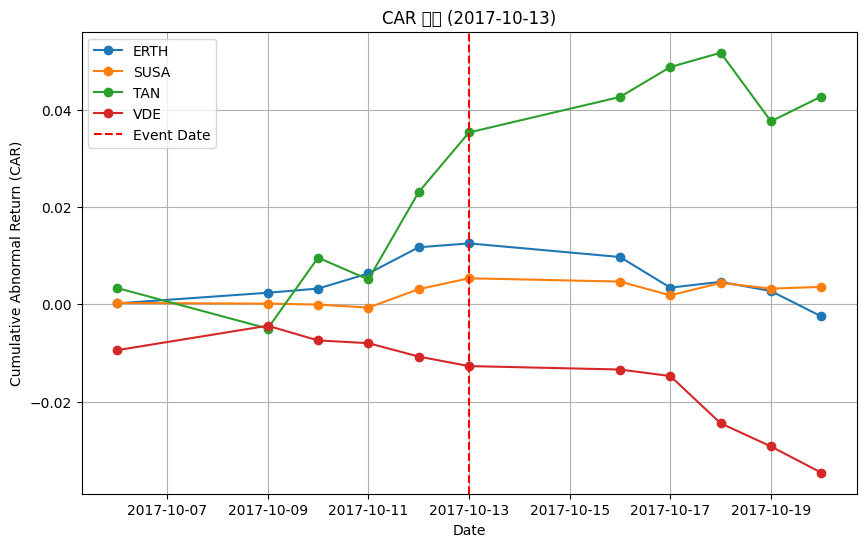

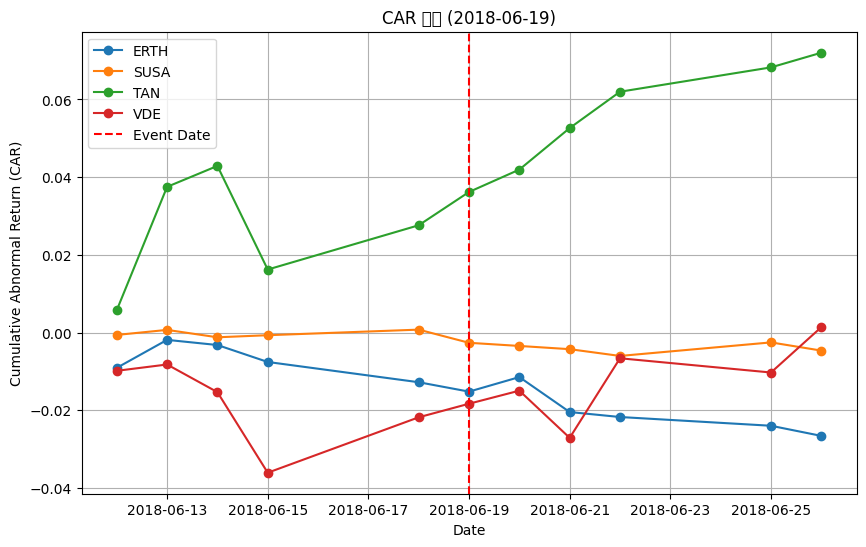

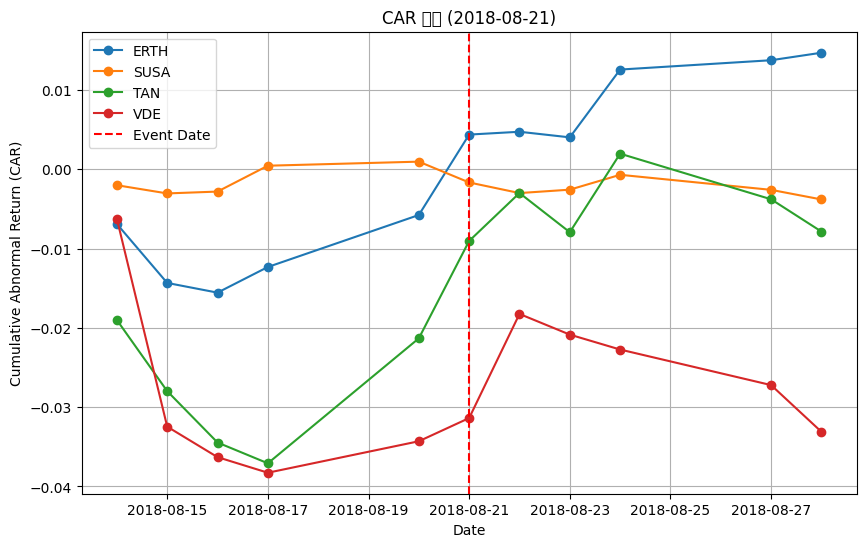

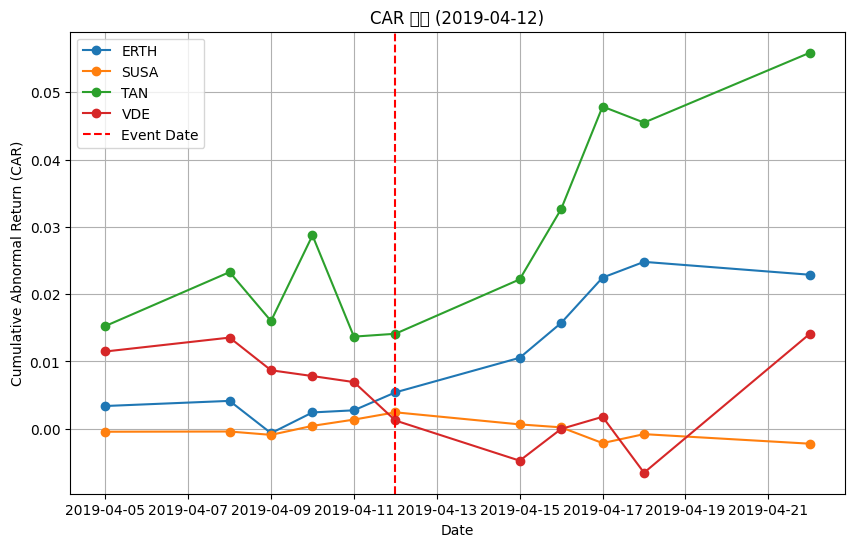

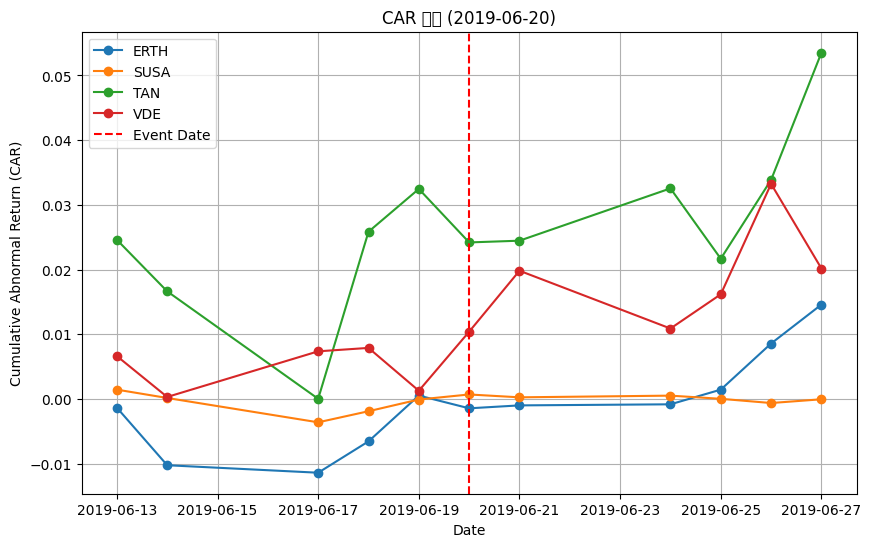

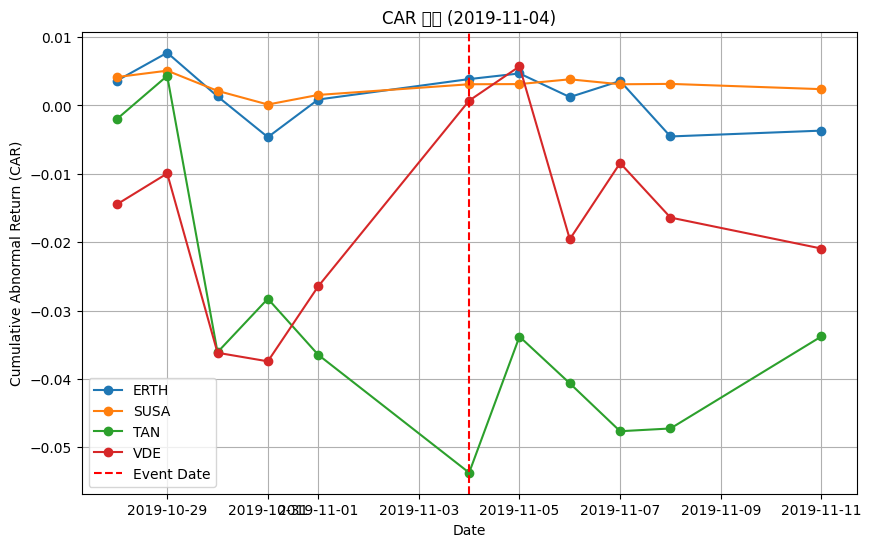

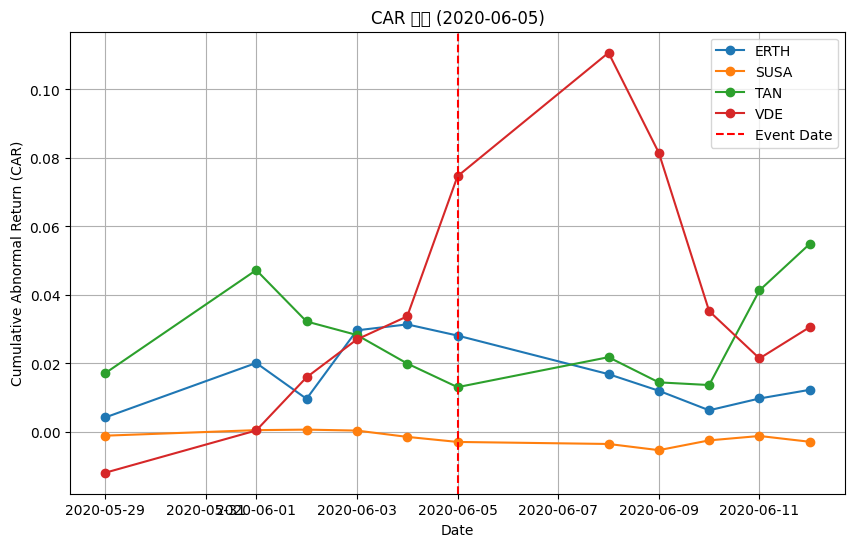

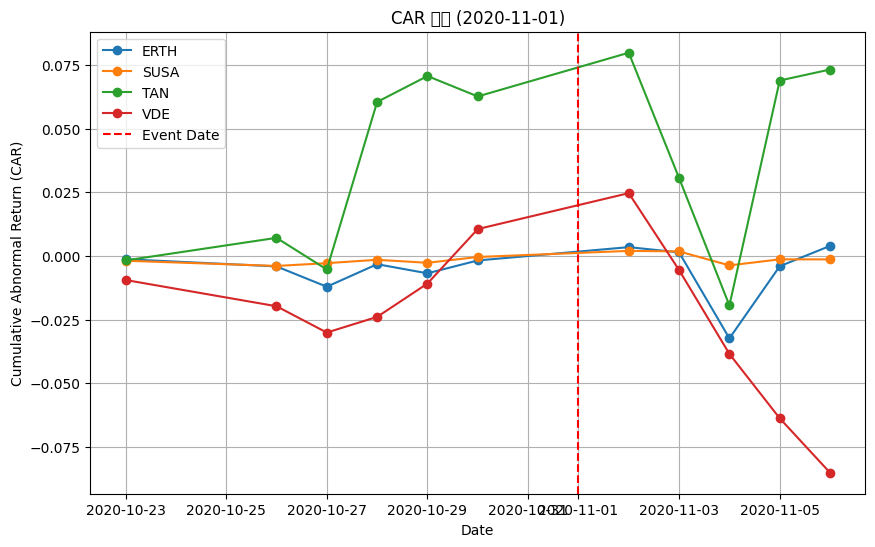

In [30]:
import matplotlib.pyplot as plt

# 📌 이벤트별 CAR 시각화
for event, etf_data in event_car.items():
    plt.figure(figsize=(10, 6))
    
    for etf, car_dict in etf_data.items():
        if car_dict is None:
            continue  # 데이터가 없으면 스킵
        
        # 날짜별 CAR 값 추출
        dates = list(car_dict.keys())
        car_values = list(car_dict.values())

        # 그래프 그리기
        plt.plot(dates, car_values, marker='o', label=etf)

    # 그래프 설정
    plt.axvline(pd.to_datetime(event), color='r', linestyle='--', label="Event Date")  # 이벤트 날짜 표시
    plt.xlabel("Date")
    plt.ylabel("Cumulative Abnormal Return (CAR)")
    plt.title(f"CAR 변화 ({event})")
    plt.legend()
    plt.grid()

    # 그래프 출력
    plt.show()


이벤트 이전1일+이후5일

C:\Users\chica\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chica\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48292 (\N{HANGUL SYLLABLE BEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chica\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chica\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chica\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 

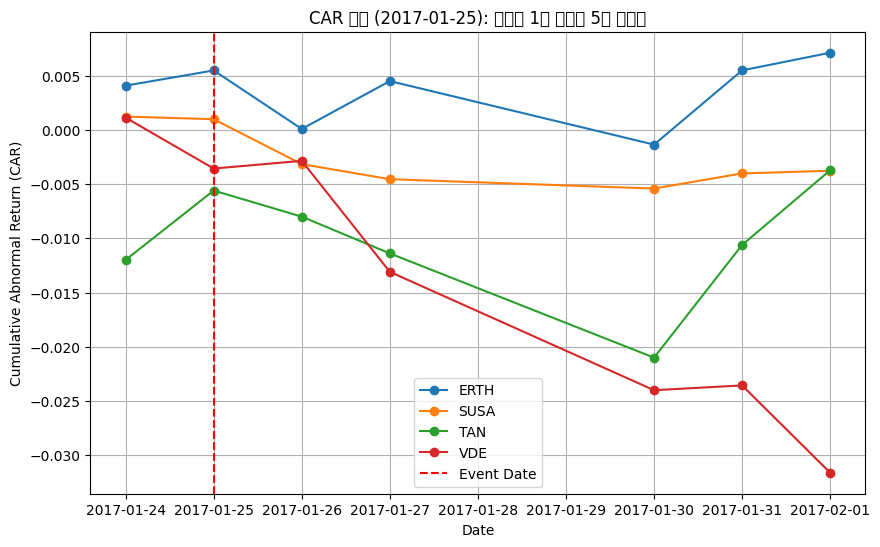

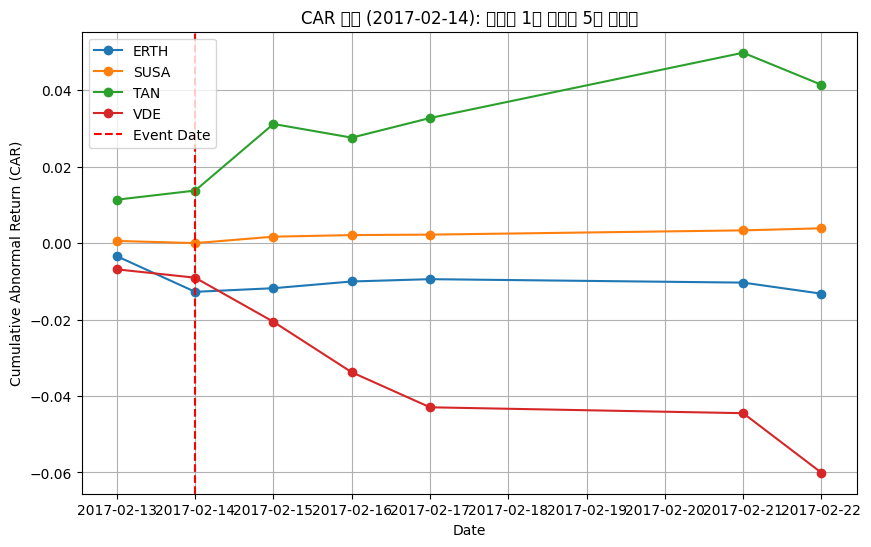

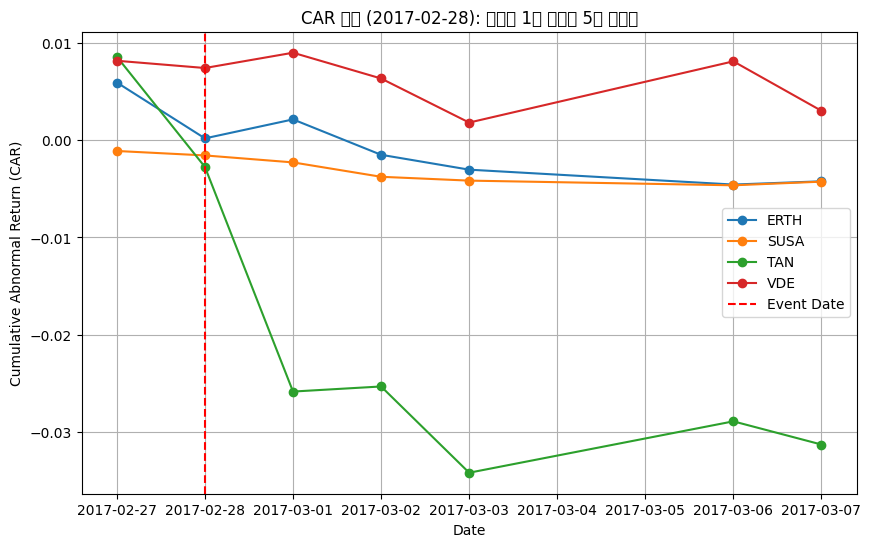

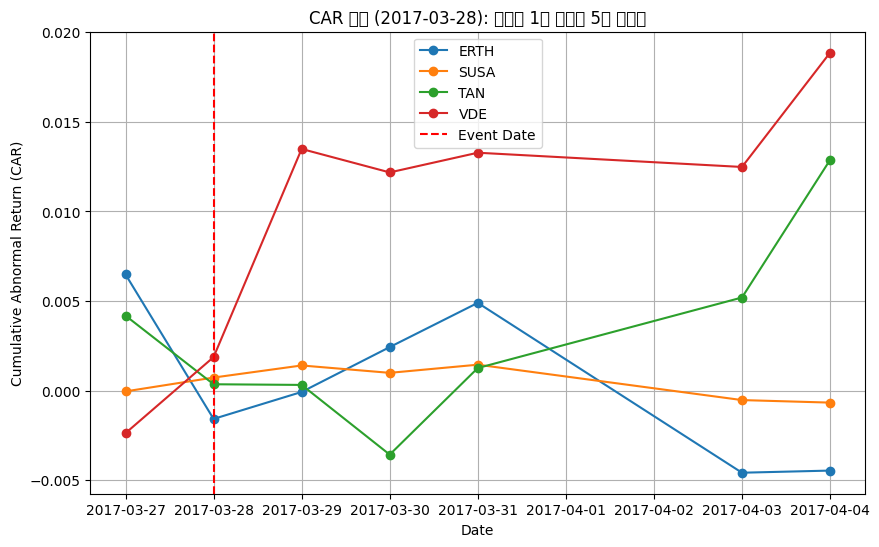

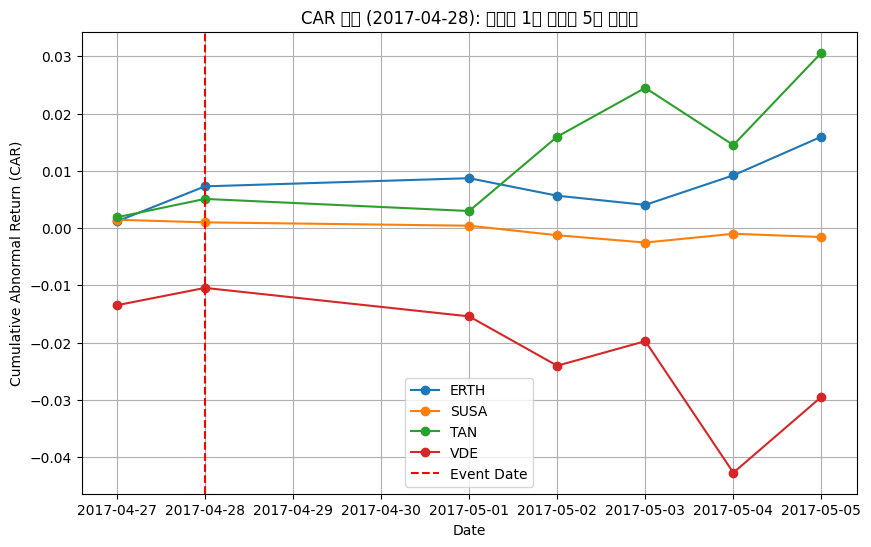

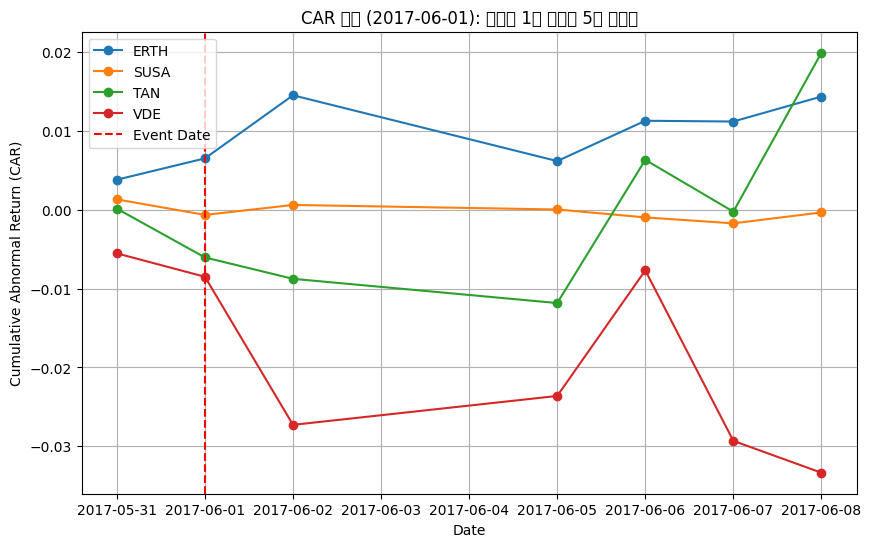

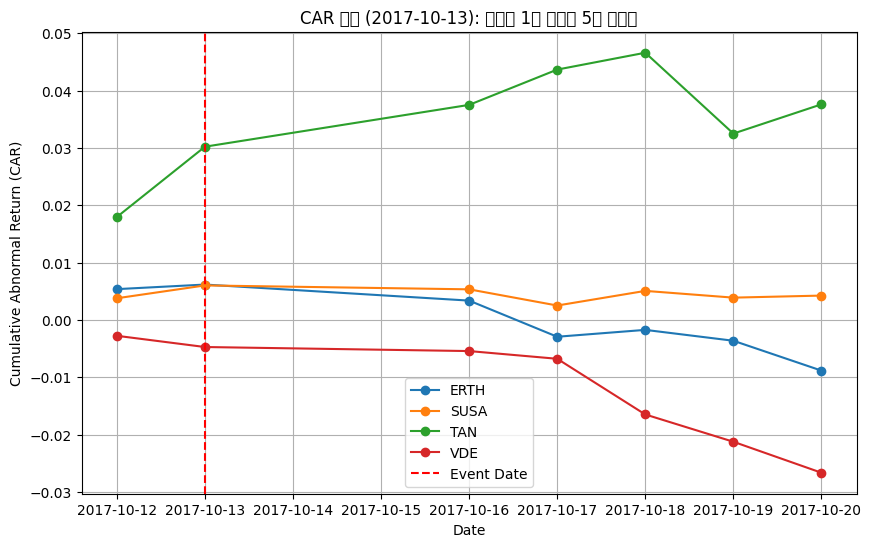

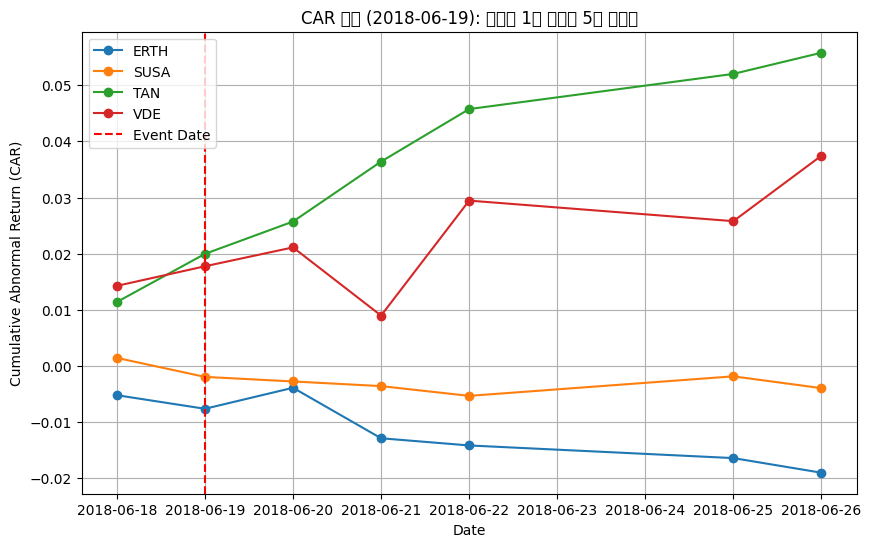

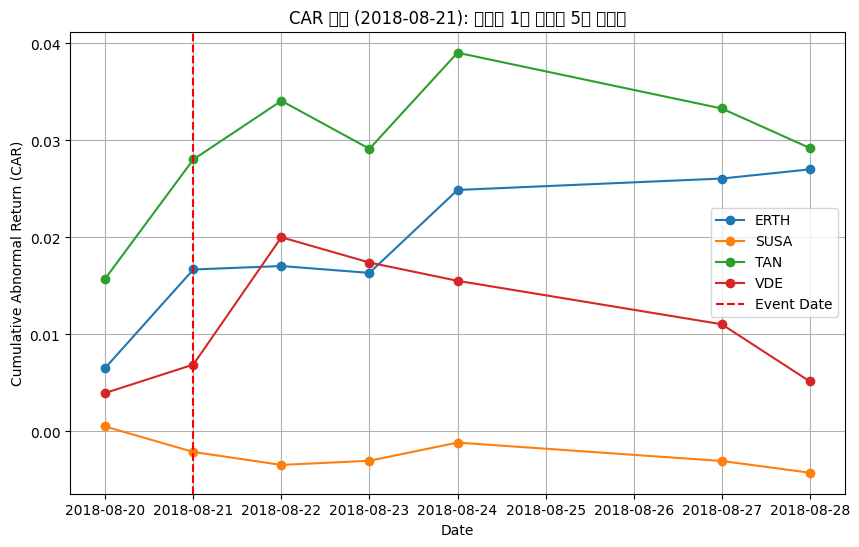

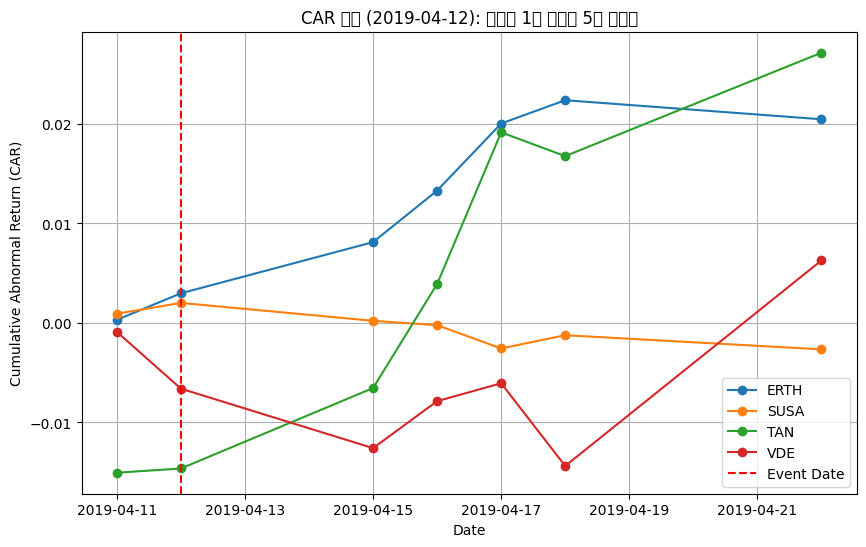

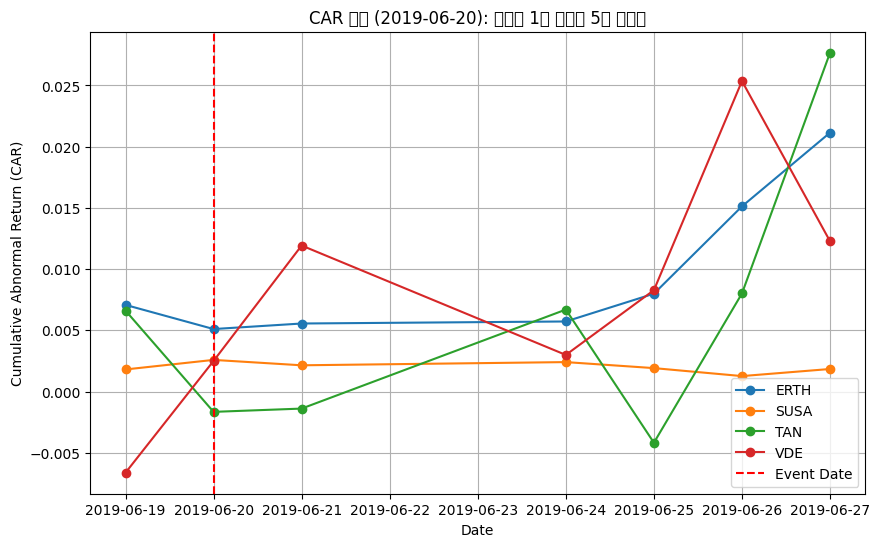

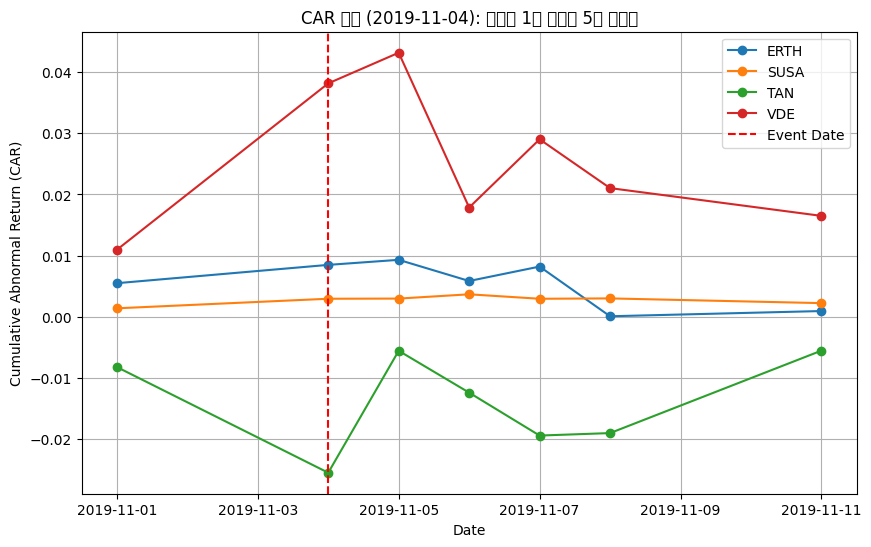

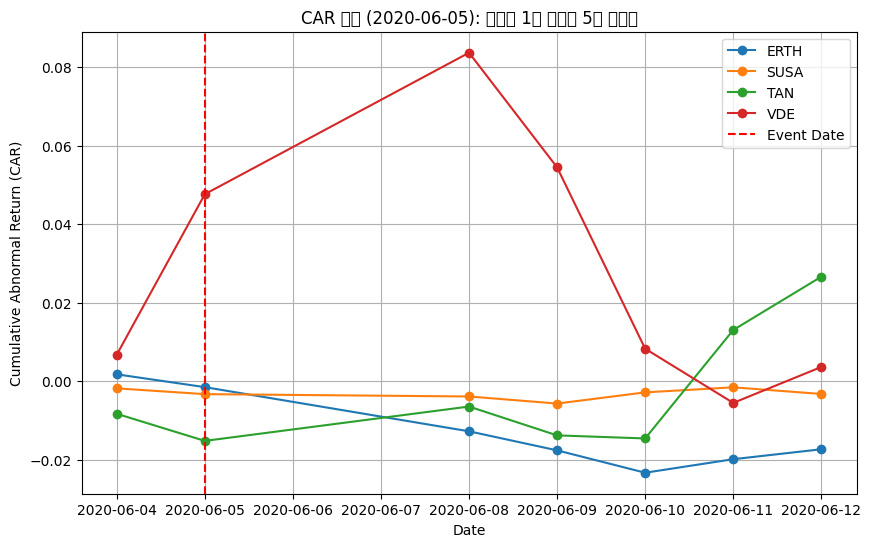

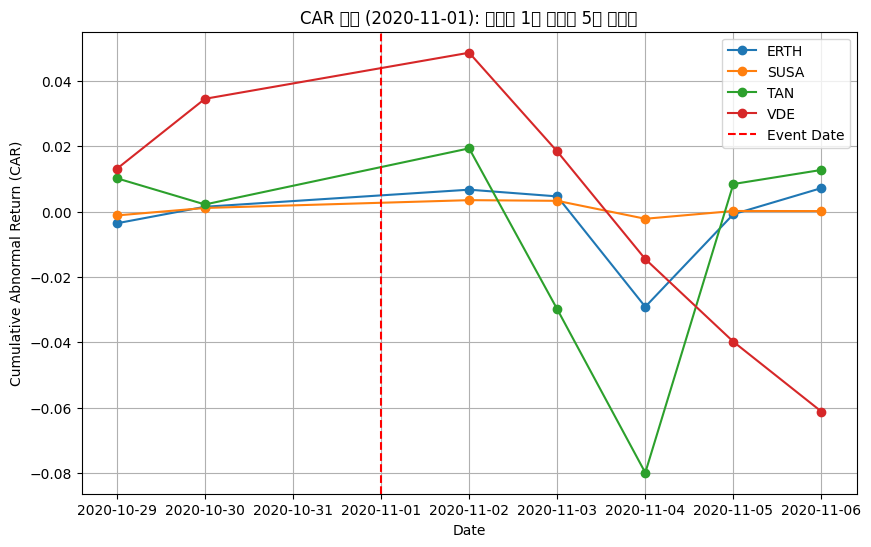

In [31]:
import matplotlib.pyplot as plt

# 📌 이벤트 전후 기간 설정: 이벤트 1일 전부터 이벤트 후 5일까지
event_window_pre = 1  # 이벤트 전 1일
event_window_post = 5  # 이벤트 후 5일
event_car_adjusted = {}

for event in event_dates:
    event_day = pd.to_datetime(event)

    # 이벤트일이 거래일이 아닐 경우, 가장 가까운 이전 거래일 찾기
    if event_day not in simple_returns.index:
        event_day = simple_returns.index[simple_returns.index.searchsorted(event_day, side='left') - 1]

    # 이벤트 전 1일 및 이벤트 후 5일 범위 설정
    idx = simple_returns.index.get_loc(event_day)  # 이벤트일의 위치 찾기
    start_idx = max(0, idx - event_window_pre)  # 이벤트 전 1일
    end_idx = min(len(simple_returns.index) - 1, idx + event_window_post)  # 이벤트 후 5일

    event_car_adjusted[event] = {}

    for etf in simple_returns.columns:
        if etf == "GSPC":
            continue  # 벤치마크 제외

        # 날짜별 CAR 계산 (이벤트 1일 전부터 5일 후까지 누적)
        cumulative_sum = 0
        daily_car = {}  # 날짜별 CAR 저장

        for d in simple_returns.index[start_idx:end_idx+1]:
            if d in abnormal_returns:
                cumulative_sum += abnormal_returns[d][etf]  # AR 누적
            daily_car[d] = cumulative_sum  # 해당 날짜까지의 누적 CAR 저장

        # 날짜별 CAR 리스트 저장
        event_car_adjusted[event][etf] = daily_car if daily_car else None  # 데이터 없으면 None

# 📌 이벤트별 CAR 시각화 (이벤트 1일 전부터 5일 후까지)
for event, etf_data in event_car_adjusted.items():
    plt.figure(figsize=(10, 6))
    
    for etf, car_dict in etf_data.items():
        if car_dict is None:
            continue  # 데이터가 없으면 스킵
        
        # 날짜별 CAR 값 추출
        dates = list(car_dict.keys())
        car_values = list(car_dict.values())

        # 그래프 그리기
        plt.plot(dates, car_values, marker='o', label=etf)

    # 그래프 설정
    plt.axvline(pd.to_datetime(event), color='r', linestyle='--', label="Event Date")  # 이벤트 날짜 표시
    plt.xlabel("Date")
    plt.ylabel("Cumulative Abnormal Return (CAR)")
    plt.title(f"CAR 변화 ({event}): 이벤트 1일 전부터 5일 후까지")
    plt.legend()
    plt.grid()

    # 그래프 출력
    plt.show()
